# 相机校准

### 目标
在本节中，我们将学习
- 由相机引起的失真类型，
- 如何找到相机的固有和非固有特性
- 如何根据这些特性使图像不失真

### 基础

一些针孔相机会给图像带来明显的失真。两种主要的变形是径向变形和切向变形。
径向变形会导致直线出现弯曲。

距图像中心越远，径向畸变越大。例如，下面显示一个图像，其中棋盘的两个边缘用红线标记。但是，您会看到棋盘的边框不是直线，并且与红线不匹配。所有预期的直线都凸出。有关更多详细信息，请访问“失真（光学）”。

![](data/calib_radial.jpg)

径向变形可以表示成如下：

$$
x_{distorted} = x( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\ y_{distorted} = y( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6)
$$

同样，由于摄像镜头未完全平行于成像平面对齐，因此会发生切向畸变。因此，图像中的某些区域看起来可能比预期的要近。切向畸变的量可以表示为：

$$
x_{distorted} = x + [ 2p_1xy + p_2(r^2+2x^2)] \\ y_{distorted} = y + [ p_1(r^2+ 2y^2)+ 2p_2xy]
$$

简而言之，我们需要找到五个参数，称为失真系数，公式如下：

$$
Distortion \; coefficients=(k_1 \hspace{10pt} k_2 \hspace{10pt} p_1 \hspace{10pt} p_2 \hspace{10pt} k_3)
$$

除此之外，我们还需要其他一些信息，例如相机的内在和外在参数。内部参数特定于摄像机。它们包括诸如焦距$(f_x，f_y)$和光学中心$(c_x,c_y)$之类的信息。焦距和光学中心可用于创建相机矩阵，该相机矩阵可用于消除由于特定相机镜头而引起的畸变。相机矩阵对于特定相机而言是唯一的，因此一旦计算出，就可以在同一相机拍摄的其他图像上重复使用。它表示为3x3矩阵：

$$
camera \; matrix = \left [ \begin{matrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{matrix} \right ]
$$

外在参数对应于旋转和平移矢量，其将3D点的坐标平移为坐标系。

对于立体声应用，首先需要纠正这些失真。要找到这些参数，我们必须提供一些定义良好的图案的示例图像（例如国际象棋棋盘）。我们找到一些已经知道其相对位置的特定点（例如棋盘上的四角）。我们知道现实世界空间中这些点的坐标，也知道图像中的坐标，因此我们可以求解失真系数。为了获得更好的结果，我们至少需要10个测试模式。

### 代码

如上所述，相机校准至少需要10个测试图案。OpenCV附带了一些国际象棋棋盘的图像（请参见samples / data / left01.jpg – left14.jpg），因此我们将利用这些图像。考虑棋盘的图像。相机校准所需的重要输入数据是3D现实世界点集以及图像中这些点的相应2D坐标。可以从图像中轻松找到2D图像点。（这些图像点是国际象棋棋盘中两个黑色正方形相互接触的位置）

真实世界中的3D点如何处理？这些图像是从静态相机拍摄的，而国际象棋棋盘放置在不同的位置和方向。因此，我们需要知道$(X,Y,Z)$值。但是为简单起见，我们可以说棋盘在XY平面上保持静止（因此Z始终为0），并且照相机也相应地移动了。这种考虑有助于我们仅找到X，Y值。现在对于X，Y值，我们可以简单地将点传递为（0,0），（1,0），（2,0），...，这表示点的位置。在这种情况下，我们得到的结果将是棋盘正方形的大小比例。但是，如果我们知道正方形大小（例如30毫米），则可以将值传递为（0,0），（30,0），（60,0），...。因此，我们得到的结果以毫米为单位。（在这种情况下，我们不知道正方形的大小，因为我们没有拍摄那些图像，因此我们以正方形的大小进行传递）。

3D点称为**对象点**，而2D图像点称为**图像点**。

#### 开始
因此，要在国际象棋棋盘中查找图案，我们可以使用函数**cv.findChessboardCorners**()。我们还需要传递所需的图案，例如8x8网格，5x5网格等。在此示例中，我们使用7x6网格。（通常，棋盘有8x8的正方形和7x7的内部角）。它返回角点和retval，如果获得图案，则为True。这些角将按顺序放置（从左到右，从上到下）

#### 另外
此功能可能无法在所有图像中找到所需的图案。因此，一个不错的选择是**编写**代码，使它启动相机并检查每帧所需的图案。获得图案后，找到角并将其存储在列表中。另外，在阅读下一帧之前请提供一些时间间隔，以便我们可以在不同方向上调整棋盘。继续此过程，直到获得所需数量的良好图案为止。即使在此处提供的示例中，我们也不确定给出的14张图像中有多少张是好的。

因此，我们必须**阅读**所有图像并仅拍摄好图像。
除了棋盘，我们还可以使用圆形网格。
在这种情况下，我们必须使用函数**cv.findCirclesGrid**()来找到模式。
较少的图像足以使用圆形网格执行相机校准。

一旦找到拐角，就可以使用**cv.cornerSubPix**()来提高其精度。我们还可以使用**cv.drawChessboardCorners**()绘制图案。所有这些步骤都包含在以下代码中：

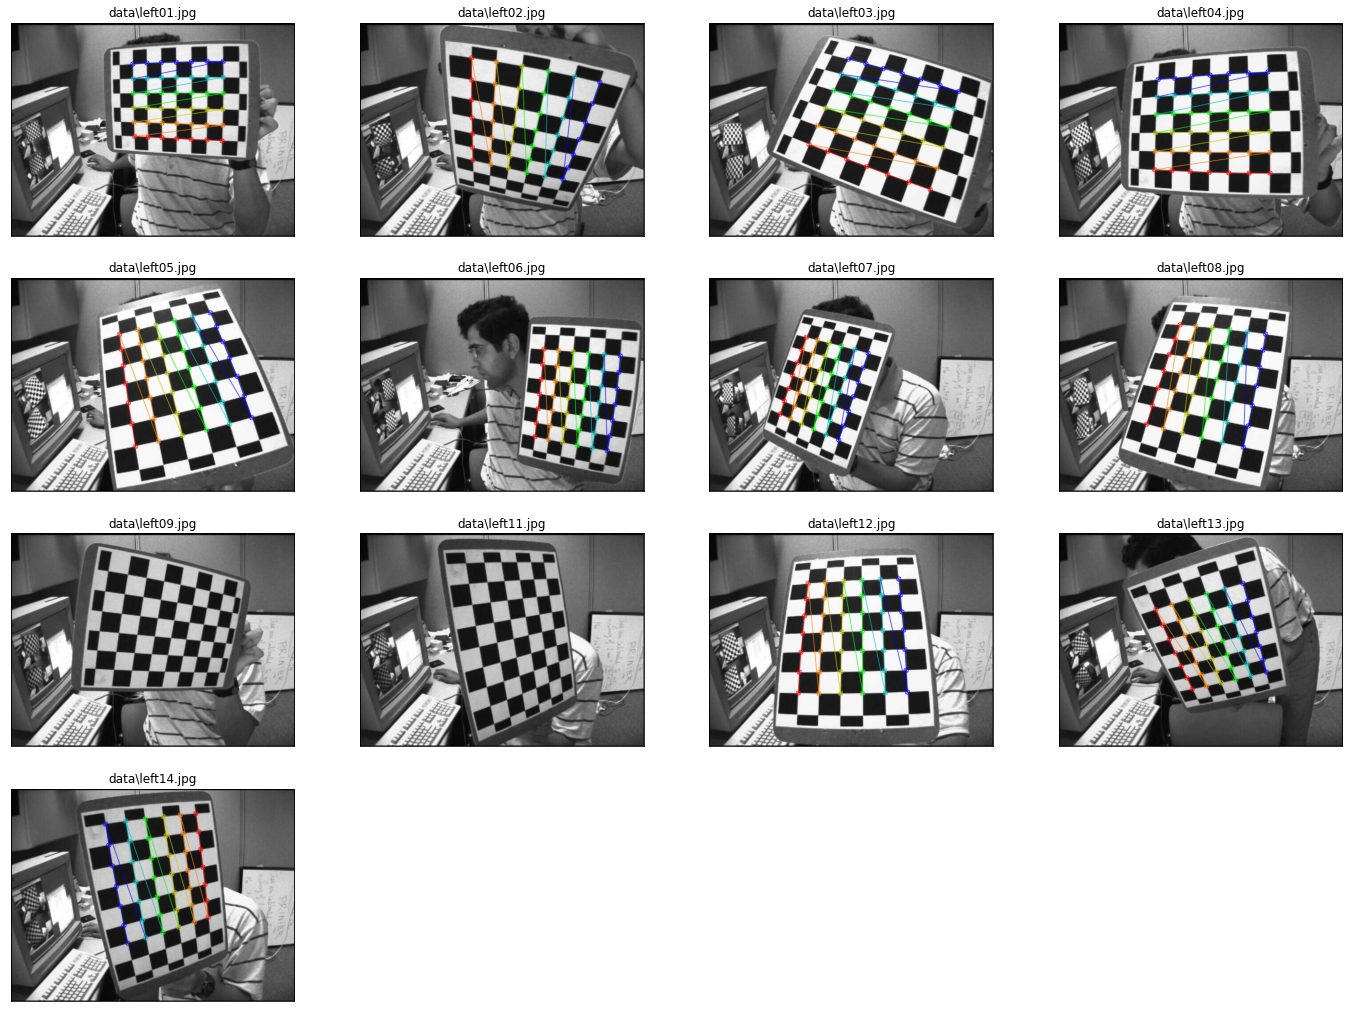

In [1]:
import numpy as np
import cv2 as cv
import glob
from matplotlib import pyplot as plt

# 终止条件
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# 准备对象点， 如 (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# 用于存储所有图像的对象点和图像点的数组。
objpoints = [] # 真实世界中的3d点
imgpoints = [] # 图像中的2d点

images = glob.glob('data/left*.jpg')

plt.figure(figsize=(24,18))

for i in range(len(images)):
    img = cv.imread(images[i])

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # 找到棋盘角落
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)

    # 如果找到，添加对象点，图像点（细化之后）
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # 绘制并显示拐角
        cv.drawChessboardCorners(img, (7,6), corners2, ret)   

    plt.subplot(4,4,i+1),plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(images[i])
    plt.xticks([]), plt.yticks([])

plt.show()

#### 校准
现在我们有了目标点和图像点，现在可以进行校准了。我们可以使用函数**cv.calibrateCamera**()返回相机矩阵，失真系数，旋转和平移矢量等。

In [2]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) 

#### 畸变校正
现在，我们可以拍摄图像并对其进行扭曲。OpenCV提供了两种方法来执行此操作。但是，首先，我们可以使用**cv.getOptimalNewCameraMatrix**()基于自由缩放参数来优化相机矩阵。如果缩放参数alpha = 0，则返回具有最少不需要像素的未失真图像。因此，它甚至可能会删除图像角落的一些像素。如果alpha = 1，则所有像素都保留有一些额外的黑色图像。此函数还返回可用于裁剪结果的图像ROI。

因此，我们拍摄一张新图像（在本例中为left12.jpg。这是本章的第一张图像）

In [3]:
img = cv.imread('data/left12.jpg')

h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

#### 1. 使用cv.undistort()
这是最简单的方法。只需调用该函数并使用上面获得的ROI裁剪结果即可。

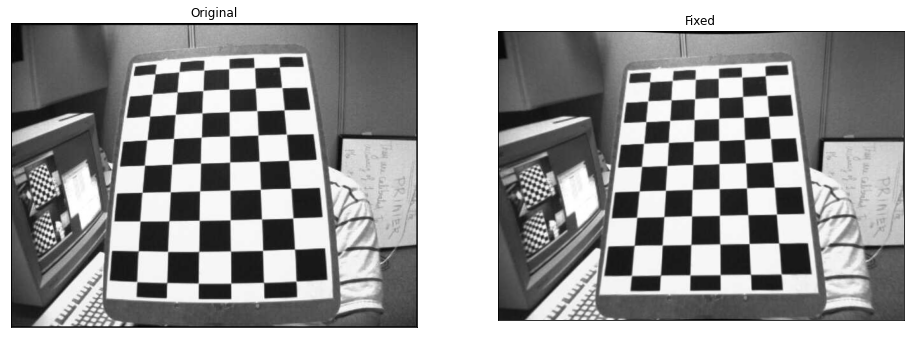

In [4]:
 # undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# 剪裁图像
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.title('Fixed')
plt.xticks([]), plt.yticks([])

plt.show()


#### 2. 使用remapping
该方式有点困难。首先，找到从扭曲图像到未扭曲图像的映射函数。然后使用重映射功能。

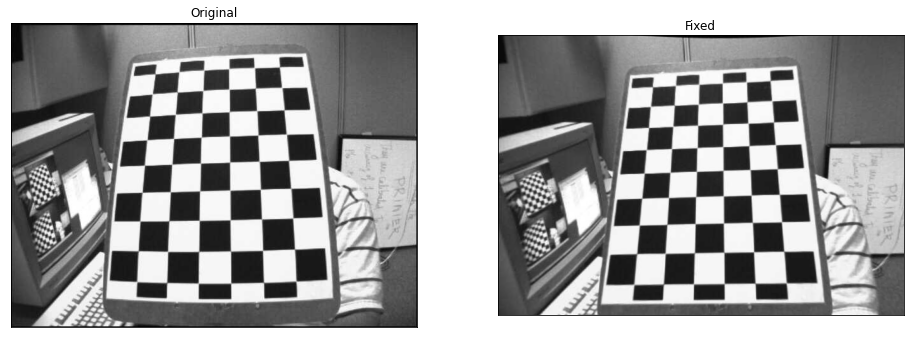

In [5]:
# undistort
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

# 裁剪图像
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.title('Fixed')
plt.xticks([]), plt.yticks([])

plt.show()

尽管如此，两种方法都给出相同的结果。

您可以看到所有边缘都是笔直的。
现在，您可以使用NumPy中的写入功能(np.savez，np.savetxt等)存储相机矩阵和失真系数，以备将来使用。

In [6]:
np.savez('output/B.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

### 重投影误差
重投影误差可以很好地估计找到的参数的精确程度。重投影误差越接近零，我们发现的参数越准确。给定固有，失真，旋转和平移矩阵，我们必须首先使用**cv.projectPoints**()将对象点转换为图像点。然后，我们可以计算出通过变换得到的绝对值和拐角发现算法之间的绝对值范数。为了找到平均误差，我们计算为所有校准图像计算的误差的算术平均值。

In [7]:
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error

print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.023686000375385676


### 附加资源
### 练习
1. 尝试使用圆形网格进行相机校准。